In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import subprocess
import logging
from ImmuneGWAS.helpers.getpaths import get_paths, get_sumstats_path
from ImmuneGWAS.helpers import dbsnp, ldlink
import ImmuneGWAS.resources.immune_GWAS as immune_GWAS
from ImmuneGWAS import config
from ImmuneGWAS.variant import Variant

from ImmuneGWAS.resources.eqtlgen import eqtlgen_trans_LDblock_query 
from ImmuneGWAS.resources.eqtlgen import eqtlgen_cis_LDblock_query 
from ImmuneGWAS.resources.tokyo_eqtl import tokyo_eqtl_LDblock_query
from ImmuneGWAS.resources.eqtl_cat import *
from IPython.display import display_html 
from IPython.display import display,HTML

from scipy.cluster import hierarchy

from ImmuneGWAS.helpers import get_gene_symbol  # convert ensembl to gene

In [19]:
ldpruned_hits = "/media/cbio3/projects/antton/Immune_cell_GWAS/data/hits_only_table_hg38_LDprunned.txt"

Designing the lookup:

1) Variant object calls trans_df lookup
2) Harmonize according to EA/OA, raise exceptions for multi-allelic SNPs
3) Split trans_df into up and down
4) Return row-scaled heatmap df where cell ordering is hard-coded and rows are resorted for clustering
5) Plotting function for heatmap df
6) Get flow phenotypes
7) Get LDTrait phenotypes
8) Summarize phenotpyes into tables with betas (remove duplicate phenotypes etc)
9) Get a single summary cis-eQTL table
10) Return summary report - 2 heatmaps for up and down, cis-eQTLs, phenotypes summarized

In [2]:
rsid = "rs1354034"
chrom = 3
pos = 56815721
EA = 'T'
OA = 'C'

x = Variant(rsid, chrom, pos, EA, OA)

In [69]:
x.get_gwas_phenotypes()

[]

In [30]:
def multi_column_df_display(list_dfs, cols=3):
    html_table = "<table style='width:100%; border:0px'>{content}</table>"
    html_row = "<tr style='border:0px'>{content}</tr>"
    html_cell = "<td style='width:{width}%;vertical-align:top;border:0px'>{{content}}</td>"
    html_cell = html_cell.format(width=100/cols)

    cells = [ html_cell.format(content=df.to_html()) for df in list_dfs ]
    cells += (cols - (len(list_dfs)%cols)) * [html_cell.format(content="")] # pad
    rows = [ html_row.format(content="".join(cells[i:i+cols])) for i in range(0,len(cells),cols)]
    display(HTML(html_table.format(content="".join(rows))))

def summary_trans(var: Variant):
    
    # retrieve trans-eQTLs
    trans = eqtlgen_trans_LDblock_query(var)
    trans.Zscore = trans.Zscore.astype(float)
    
    
    # check EA for sign of beta
    
    if set(trans.AssessedAllele == x.EA) == {True}:
        trans.Zscore = trans.Zscore * -1
    
    # split into up and down genes
    up = trans[trans.Zscore>0]
    down = trans[trans.Zscore<0]
    up = up.Gene
    down = down.Gene
    
    # dictionary to map ensembl to gene name
    mapper = dict(zip(trans.Gene, trans.GeneSymbol))
    
    #get ge matrix from ImmunexUT
    paths = get_paths(root='/media/')
    ge = pd.read_csv(paths['ge_tokyo'], sep='\t')
    ge = ge.set_index("Gene_id")
    ge = ge.drop("Gene_name", axis=1)
    ge = ge.drop_duplicates()
    
    # get indices for trans-eQTL matrix
    # note any missing genes will be dropped
    
    u = [i for i in up if i in ge.index]
    u = set(u)
    d = [i for i in down if i in ge.index]
    d = set(d)
    
    # filter gene expression matrix into up and down genes
    u = ge.loc[u]
    d = ge.loc[d]
    
    # rename ensembl IDs to gene names
    u.index = u.index.map(mapper)
    d.index = d.index.map(mapper)

    # hard-code order of cell types according to gene expression similarity on whole GE matrix
    
    ordered_cols = ['Plasmablast', 'LDG', 'Neu', 'pDC', 'mDC', 'CL_Mono', 'Int_Mono',
           'CD16p_Mono', 'NC_Mono', 'Naive_B', 'USM_B', 'DN_B', 'SM_B', 'NK',
           'Mem_CD8', 'EM_CD8', 'TEMRA_CD8', 'Naive_CD8', 'Fr_I_nTreg',
           'Naive_CD4', 'Fr_III_T', 'Fr_II_eTreg', 'CM_CD8', 'Th2', 'Tfh', 'Th17',
           'Mem_CD4', 'Th1']
    
    # normalize up and down genes

    def standard_scale(x):
        return (x-x.min())/x.max()

    u = u.apply(standard_scale, axis=1)
    d = d.apply(standard_scale, axis=1)

    # reorder columns
    
    u = u.loc[:, ordered_cols]
    d = d.loc[:, ordered_cols]
    
    # reoder rows by dendrogram
    if len(u)>1:
        Z = hierarchy.linkage(u, optimal_ordering=True, method='ward')
        dendro = hierarchy.dendrogram(Z, no_plot=True)
    
        u = u.iloc[dendro['leaves'],:]
    
    if len(d)>1:
        Z = hierarchy.linkage(d, optimal_ordering=True, method='ward')
        dendro = hierarchy.dendrogram(Z, no_plot=True)
        d = d.iloc[dendro['leaves'],:]
    # collect all my cis-eqtls

    tokyo_eqtl_LDblock_query(x)
    eqtlgen_cis_LDblock_query (x)
    eqtl_catalogue_LDblock_query_type_restricted_multitype(x)

    # now all of these are in the Results object

    gwas = ldlink.ldtrait(x)

    # first try to filter by the same SNP as in Variant object, otherwise filter down to one rsid
    
    tokyo = x.results.tokyo_eqtl()[x.results.tokyo_eqtl()['Variant_ID']==x.rsid]
    
    if len(tokyo)>0:
        tokyo = tokyo[['Gene_name','Variant_ID', 'Backward_slope', 'Backward_P', 'cell_type']]
        tokyo = tokyo.sort_values(by='Gene_name')
    
    elif len(tokyo)==0:
        tokyo = x.results.tokyo_eqtl()
        rsid = tokyo['Variant ID'][0]
        

    
    cat = x.results.eqtl_cat()
    cat = cat[cat.position==str(x.pos)]
    cat = cat[['gene_symbol', 'z', 'study', 'cell_type']]
    
    
    gwas_traits = set(x.results.ldtrait()['GWAS Trait'].tolist())
    
    
    
    cisgen = x.results.eqtlgen_cis()
    cisgen = cisgen[cisgen.SNP==x.rsid]
    if len(cisgen)>0:
        cisgen = cisgen[['SNP', 'Zscore', 'Pvalue', 'GeneSymbol']].sort_values(by='GeneSymbol')
    elif len(csigen)==0:
        cisgen = x.results.eqtlgen_cis()
        rsid = cisgen.SNP[0]
        cisgen = cisgen[cisgen.SNP==rsid]
        cisgen = cisgen[['SNP', 'Zscore', 'Pvalue', 'GeneSymbol']].sort_values(by='GeneSymbol')
    # get the cis-eqtl genes to plot a heatmap of the cis-eQTL genes
    
    a = x.results.eqtlgen_cis_df['Gene']

    b = x.results.tokyo_eqtl_df['Gene_id'].apply(lambda x:x.split(".")[0])

    c = x.results.eqtl_cat_df['molecular_trait_id']
    
    cis_genes = list(set(pd.concat([a,b,c]).tolist()))
    cis_genes = [i for i in cis_genes if i in ge.index]
    cis_genes = ge.loc[cis_genes]
    cis_genes = cis_genes.apply(standard_scale, axis=1)
    cis_genes = cis_genes.loc[:, ordered_cols]
    cis_genes.index = cis_genes.index.map(get_gene_symbol)
    
    list_dfs = [tokyo, cat, cisgen]

    display(tokyo)
    display(cat)
    display(cisgen)
    print("GWAS Catalog\n")
    display(gwas_traits)
    print("Flow phenos\n")
    display(x.get_gwas_phenotypes())
    
    sns.heatmap(cis_genes, cbar=False, cmap='inferno', square=True)
    
    h = max([len(u), len(d)])
    h = int(h/10)
    
    if len(d)>0 and len(u)>0:
        fig, ax= plt.subplots(1,2, figsize=(20,h))

        sns.heatmap(u, ax=ax[0], cbar=False, cmap='inferno')
        sns.heatmap(d, ax=ax[1], cbar=False, cmap='inferno')
    
        ax[0].set_title("UP Trans genes")
        ax[1].set_title("DOWN Trans genes")
    
    elif len(d)==0 and len(u)>0:
        fig, ax = plt.subplots(figsize=(20,h))
        sns.heatmap(u, ax=ax, cbar=False, cmap='inferno')
        ax.set_title("UP Trans genes")
    
    elif len(d)>0 and len(u)==0:
        fig, ax = plt.subplots(figsize=(20,h))
        sns.heatmap(d, ax=ax, cbar=False, cmap='inferno')
        ax.set_title("DOWN Trans genes")
                               
    elif len(d)==0 and len(u)==0:
        print("no significant trans-eQTL detected")
        
    display(u)

In [3]:
rsid = 'rs10004195'
EA = 'T'
OA = 'A'
pos = 38783103
chrom = 4

x = Variant(rsid, chrom, pos, EA, OA)

,Gene_name,Variant_ID,Backward_slope,Backward_P,cell_type
1,KLHL5,rs10004195,-0.0106689,0.879064,Th17
2,KLHL5,rs10004195,-0.0184947,0.791956,Th17
3,KLHL5,rs10004195,0.306984,9.38593e-06,Th17
0,TLR1,rs10004195,0.591541,1.05137e-11,CM_CD8
1,TLR1,rs10004195,-0.261576,4.25927e-22,Neu
1,TLR1,rs10004195,-0.261571,1.53572e-10,LDG
0,TLR1,rs10004195,-0.12285,3.62309e-07,CD16p_Mono
0,TLR1,rs10004195,0.550155,4.44894e-17,TEMRA_CD8
0,TLR1,rs10004195,0.172011,5.90091e-06,Tfh
1,TLR1,rs10004195,-0.256717,1.60515e-10,Naive_B


,gene_symbol,z,study,cell_type
0,TLR1,6.830311,Alasoo_2018,macrophage_Salmonella
0,TLR1,-7.738825,CEDAR,monocyte_CD14
0,TLR1,-7.125939,CEDAR,B-cell_CD19
0,TLR1,-8.756535,Fairfax_2014,monocyte_LPS2
0,TLR1,-8.684713,Fairfax_2014,monocyte_LPS24
0,TLR1,-8.433946,Gilchrist_2021,NK-cell_naive
0,TLR1,-7.616854,Fairfax_2014,monocyte_IFN24


,SNP,Zscore,Pvalue,GeneSymbol
2,rs10004195,13.0028,1.1825e-38,FAM114A1
1,rs10004195,11.3747,5.5959e-30,KLHL5
4,rs10004195,-7.522,5.3862e-14,TLR10
0,rs10004195,-6.3183,2.6429e-10,TLR6
3,rs10004195,8.8413,9.469600000000001e-19,TMEM156


GWAS Catalog



{'Alcohol consumption',
 'Allergic disease (asthma, hay fever and/or eczema) (age of onset)',
 'Allergic disease (asthma, hay fever and/or eczema) (multivariate analysis)',
 'Allergic disease (asthma, hay fever or eczema)',
 'Allergic sensitization',
 'Asthma',
 'Asthma (moderate or severe)',
 'Asthma and hay fever',
 'Asthma or allergic disease (pleiotropy)',
 'Atopic dermatitis',
 'Breast cancer',
 'C-C motif chemokine 3 levels',
 'C-C motif chemokine 4 levels',
 'Hay fever and/or eczema',
 'Helicobacter pylori serologic status',
 'Limited cutaneous systemic scleroderma'}

Flow phenos



[]

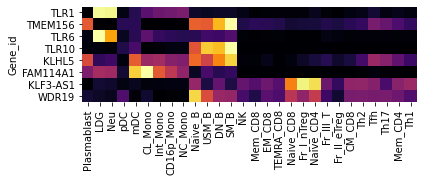

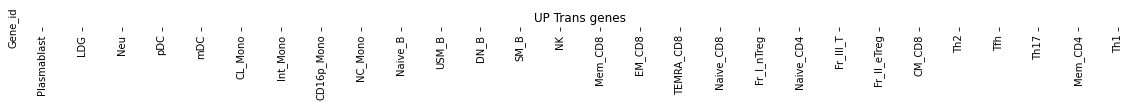

In [31]:
summary_trans(x)

In [22]:
cisgen = x.results.eqtlgen_cis()
cisgen = cisgen[cisgen.SNP==x.rsid]

cisgen = cisgen[['SNP', 'Zscore', 'Pvalue', 'GeneSymbol']].sort_values(by='GeneSymbol')

,SNP,Zscore,Pvalue,GeneSymbol
2,rs10004195,13.0028,1.1825e-38,FAM114A1
1,rs10004195,11.3747,5.5959e-30,KLHL5
4,rs10004195,-7.522,5.3862e-14,TLR10
0,rs10004195,-6.3183,2.6429e-10,TLR6
3,rs10004195,8.8413,9.469600000000001e-19,TMEM156


In [24]:
cisgen.SNP[0]

'rs10004195'